# Imports

In [149]:
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from snowballstemmer.dutch_stemmer import DutchStemmer
from nltk.corpus import stopwords

In [5]:
import re

# Data Reading

In [6]:
data = pd.read_excel('Heijmans data final.xlsx')

In [7]:
data = data[['Categorie ongeval','Beschrijving incident']].dropna()

In [9]:
print(data)

                        Categorie ongeval  \
0                              Aanrijding   
1                              Aanrijding   
2                              Aanrijding   
3                              Aanrijding   
4                              Aanrijding   
...                                   ...   
3302  Vallen (van personen of voorwerpen)   
3303  Vallen (van personen of voorwerpen)   
3304  Vallen (van personen of voorwerpen)   
3305  Vallen (van personen of voorwerpen)   
3306  Vallen (van personen of voorwerpen)   

                                  Beschrijving incident  
0     Materialen in de bus slingeren los. Imperiaal ...  
1     Slachtoffer is aangereden in zijn bedrijfsauto...  
2     Fietspad niet afgeschermd van werkverkeer/terr...  
3     Aanrijding van een verkeersregelaar door een p...  
4     Veegwagen van Wolfswinkel reed (rond 14:50)teg...  
...                                                 ...  
3302  Bij het legen / openen van een big bag is Henk.

In [8]:
data.columns = ['Category', 'Text']

In [9]:
cats = ['Aanrijding',
'Agressie en extreme lichamelijke inspanning',
'Andere vormen van contact met voorwerpen',
'BHV inzet op locatie',
'Gevaarlijke stoffen, brand en explosies',
'Machines en handgereedschap',
'Vallen (van personen of voorwerpen)']


In [11]:
data = data[data['Category'].isin(cats)]

# Data Cleaning

### The following are done to clean the data:
- Lowering all the text
- Removing dutch stopwords
- Stemming

In [12]:
dutch = DutchStemmer()

In [13]:
all_stopwords = stopwords.words('dutch')

In [16]:
print(all_stopwords)

['de', 'en', 'van', 'ik', 'te', 'dat', 'die', 'in', 'een', 'hij', 'het', 'niet', 'zijn', 'is', 'was', 'op', 'aan', 'met', 'als', 'voor', 'had', 'er', 'maar', 'om', 'hem', 'dan', 'zou', 'of', 'wat', 'mijn', 'men', 'dit', 'zo', 'door', 'over', 'ze', 'zich', 'bij', 'ook', 'tot', 'je', 'mij', 'uit', 'der', 'daar', 'haar', 'naar', 'heb', 'hoe', 'heeft', 'hebben', 'deze', 'u', 'want', 'nog', 'zal', 'me', 'zij', 'nu', 'ge', 'geen', 'omdat', 'iets', 'worden', 'toch', 'al', 'waren', 'veel', 'meer', 'doen', 'toen', 'moet', 'ben', 'zonder', 'kan', 'hun', 'dus', 'alles', 'onder', 'ja', 'eens', 'hier', 'wie', 'werd', 'altijd', 'doch', 'wordt', 'wezen', 'kunnen', 'ons', 'zelf', 'tegen', 'na', 'reeds', 'wil', 'kon', 'niets', 'uw', 'iemand', 'geweest', 'andere']


In [14]:
def clean_text(text):
    text = text.lower() # Convert the text to lower case
    text = re.sub(',', ' ', text) # Replace commas with an extra space
    
    text = re.sub('<.*?>', '', text) # Clean out any HTML tags
    text = re.sub('\s+',' ', text) # Replace multiple spaces with 
    
    text = text.split()
    
    text = [re.sub('[^\w]', '', i.rstrip()) for i in text if i not in all_stopwords] # Clean out stopwords
    
    text = dutch.stemWords(text)# Dutch Stemming
    
    text = ' '.join(text)
    return text

In [15]:
data['Text'] = data['Text'].apply(clean_text)
data['Text'].describe()

count                                     2826
unique                                    2521
top       ligg tevel losligg material bouwplat
freq                                        27
Name: Text, dtype: object

# Model without up/down sampling 

In [155]:
x = data['Text']
y = data['Category']

In [156]:
X, test_x, y, test_y = train_test_split(x, y, test_size=0.10, random_state=0, shuffle=True)
tf = TfidfVectorizer()
tf.fit(X)
len(tf.get_feature_names())


7337

In [155]:
print(len(test_x))
print(len(x))

283
2826


In [157]:
X1 = X
X = tf.transform(X)
test_X = tf.transform(test_x)


In [19]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

In [87]:
from sklearn.metrics import classification_report

# Using Random Forest Classifier

In [50]:
params = {
    'n_estimators': [50, 100, 200],
    # 'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}
kf = KFold(n_splits=4, random_state=42, shuffle=False)

In [80]:
imba_pipeline_RFC = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
cross_val_score(imba_pipeline_RFC, X, y,  cv=kf).mean()

0.7015339474075174

In [81]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imbaRFC = GridSearchCV(imba_pipeline_RFC, param_grid=new_params , scoring='f1_macro', n_jobs=-1, verbose=3, cv=kf,
                        return_train_score=True)

In [82]:
grid_imbaRFC.fit(X,y)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   57.4s remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.8min finished


GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='f1_macro', verbose=3)

In [83]:
grid_imbaRFC.best_params_

{'randomforestclassifier__n_estimators': 200,
 'randomforestclassifier__random_state': 13}

In [84]:
grid_imbaRFC.best_score_

0.5113224232739596

### Checking predict score

In [88]:
y_test_predictRFC = grid_imbaRFC.predict(test_X)
recall_score(test_y, y_test_predictRFC, average='macro')

0.47647128631907654

### Checking best estimator predict score

In [89]:
y_test_predictRFC = grid_imbaRFC.best_estimator_.named_steps['randomforestclassifier'].predict(test_X)
recall_score(test_y, y_test_predictRFC, average="macro")

0.47647128631907654

In [91]:
print(classification_report(test_y, y_test_predictRFC))

precision    recall  f1-score   support

                                 Aanrijding       0.89      0.42      0.57        19
Agressie en extreme lichamelijke inspanning       0.50      0.22      0.31         9
   Andere vormen van contact met voorwerpen       0.54      0.26      0.35        57
                       BHV inzet op locatie       0.89      0.62      0.73        13
    Gevaarlijke stoffen, brand en explosies       0.57      0.29      0.38        14
                Machines en handgereedschap       0.46      0.66      0.54        41
        Vallen (van personen of voorwerpen)       0.68      0.87      0.76       130

                                   accuracy                           0.63       283
                                  macro avg       0.65      0.48      0.52       283
                               weighted avg       0.63      0.63      0.60       283



In [140]:
print(grid_imbaRFC.best_estimator_.named_steps['randomforestclassifier'].feature_importances_)

[1.10869175e-06 1.51978492e-04 3.58299385e-06 ... 1.03965771e-06
 5.02683753e-06 1.07101085e-05]


In [161]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

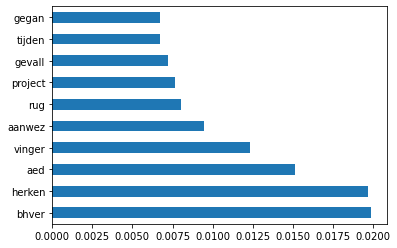

In [163]:
feat_importancesRFC = pd.Series(grid_imbaRFC.best_estimator_.named_steps['randomforestclassifier'].feature_importances_, index=tf.get_feature_names())
feat_importancesRFC.nlargest(10).plot(kind='barh')
plt.show()

# Train/Split/Validate


# Using Logistic Regression


In [94]:
imba_pipelineLR = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(C=10, penalty='l2'))
cross_val_score(imba_pipelineLR, X, y,  cv=kf).mean()

0.7215873074827911

In [95]:
params_1 = {
    'C': [5, 10],
    'penalty':['l1', 'l2'] 
    }
new_params = {'logisticregression__' + key: params_1[key] for key in params_1}
grid_imbaLR = GridSearchCV(imba_pipelineLR, param_grid=new_params, cv=kf, 
                        return_train_score=True)

In [96]:
grid_imbaLR.fit(X,y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(C=10))]),
             param_grid={'logisticregression__C': [5, 10],
                         'logisticregression__penalty': ['l1', 'l2']},
             return_train_score=True)

In [97]:
grid_imbaLR.best_params_

{'logisticregression__C': 5, 'logisticregression__penalty': 'l2'}

In [98]:
grid_imbaLR.best_score_

0.7243425939682069

### Checking predict score

In [99]:
y_test_predictLR = grid_imbaLR.predict(test_X)
recall_score(test_y, y_test_predictLR, average='macro')

0.5971123869711803

### Checking best estimator predict score

In [100]:
y_test_predictLR = grid_imbaLR.best_estimator_.named_steps['logisticregression'].predict(test_X)
recall_score(test_y, y_test_predictLR, average="macro")

0.5971123869711803

In [101]:
print(classification_report(test_y, y_test_predictLR))

precision    recall  f1-score   support

                                 Aanrijding       0.83      0.79      0.81        19
Agressie en extreme lichamelijke inspanning       0.75      0.33      0.46         9
   Andere vormen van contact met voorwerpen       0.56      0.40      0.47        57
                       BHV inzet op locatie       0.73      0.62      0.67        13
    Gevaarlijke stoffen, brand en explosies       0.54      0.50      0.52        14
                Machines en handgereedschap       0.56      0.71      0.62        41
        Vallen (van personen of voorwerpen)       0.75      0.83      0.79       130

                                   accuracy                           0.68       283
                                  macro avg       0.67      0.60      0.62       283
                               weighted avg       0.68      0.68      0.67       283



In [141]:
print(grid_imbaLR.best_estimator_.named_steps['logisticregression'].feature_importances_)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# Using Support Vector Machine

In [31]:
from sklearn.svm import LinearSVC

In [102]:
imba_pipelineSVC = make_pipeline(SMOTE(random_state=42), 
                              LinearSVC(penalty="l1", loss='squared_hinge',dual=False ))
cross_val_score(imba_pipelineSVC, X, y,  cv=kf).mean()

0.7062496904868023

In [103]:
params_2 = {
    'C': [5, 10],
    'penalty':['l1', 'l2'] 
    }
new_params = {'linearsvc__' + key: params_2[key] for key in params_2}
grid_imbaSVC = GridSearchCV(imba_pipelineSVC, param_grid=new_params, cv=kf, 
                        return_train_score=True)

In [104]:
grid_imbaSVC.fit(X,y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('linearsvc',
                                        LinearSVC(dual=False, penalty='l1'))]),
             param_grid={'linearsvc__C': [5, 10],
                         'linearsvc__penalty': ['l1', 'l2']},
             return_train_score=True)

In [105]:
grid_imbaSVC.best_params_

{'linearsvc__C': 5, 'linearsvc__penalty': 'l1'}

In [106]:
grid_imbaSVC.best_score_

0.7019183627989898

### Checking predict score

In [107]:
y_test_predictSVC = grid_imbaSVC.predict(test_X)
recall_score(test_y, y_test_predictSVC, average='macro')

0.511528127922773

### Checking best estimator predict score

In [108]:
y_test_predictSVC = grid_imbaSVC.best_estimator_.named_steps['linearsvc'].predict(test_X)
recall_score(test_y, y_test_predictSVC, average="macro")

0.511528127922773

In [109]:
print(classification_report(test_y, y_test_predictSVC))

precision    recall  f1-score   support

                                 Aanrijding       0.62      0.68      0.65        19
Agressie en extreme lichamelijke inspanning       0.14      0.11      0.12         9
   Andere vormen van contact met voorwerpen       0.54      0.39      0.45        57
                       BHV inzet op locatie       0.80      0.62      0.70        13
    Gevaarlijke stoffen, brand en explosies       0.44      0.29      0.35        14
                Machines en handgereedschap       0.55      0.68      0.61        41
        Vallen (van personen of voorwerpen)       0.74      0.82      0.77       130

                                   accuracy                           0.64       283
                                  macro avg       0.55      0.51      0.52       283
                               weighted avg       0.63      0.64      0.63       283



In [143]:
print(grid_imbaSVC.feature_importances_)

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

# =================================================================

In [156]:
cats = ['Aanrijding',
'Agressie en extreme lichamelijke inspanning',
'Andere vormen van contact met voorwerpen',
'BHV inzet op locatie',
'Gevaarlijke stoffen, brand en explosies',
'Machines en handgereedschap',
'Vallen (van personen of voorwerpen)']


In [119]:
xDF = data["Text"]
yDF = data["Category"]
x_train, x_test, y_train, y_test = train_test_split(xDF, yDF, test_size=0.1, random_state=0, shuffle=True)

X_train, val_x, Y_train, val_y = train_test_split(x_train, y_train, test_size=0.1, random_state=0, shuffle=True)

In [120]:
tf = TfidfVectorizer()
tf.fit(X_train)

TfidfVectorizer()

In [121]:
X_train = tf.transform(X_train)
X_test = tf.transform(x_test)
val_x = tf.transform(val_x)

In [160]:
cv = y.value_counts()[0]

In [ ]:
print (cv)

# Baseline

In [124]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)
dummy_score = dummy_clf.score(X_test, y_test)
print(dummy_score)

0.45936395759717313


In [123]:
from sklearn.svm import LinearSVC
SVM_cl= LinearSVC(penalty="l1", loss='squared_hinge',dual=False )
SVM_cl.fit(X_train,Y_train)


LinearSVC(dual=False, penalty='l1')

In [127]:
SVM_cl.score(val_x, val_y)

0.7568627450980392

In [128]:
preds = SVM_cl.predict(val_x)

In [130]:
print(classification_report(val_y, preds))

precision    recall  f1-score   support

                                 Aanrijding       0.89      0.62      0.73        13
Agressie en extreme lichamelijke inspanning       1.00      0.50      0.67         2
   Andere vormen van contact met voorwerpen       0.63      0.51      0.56        43
                       BHV inzet op locatie       1.00      0.62      0.76        13
    Gevaarlijke stoffen, brand en explosies       0.33      0.20      0.25         5
                Machines en handgereedschap       0.61      0.61      0.61        33
        Vallen (van personen of voorwerpen)       0.80      0.91      0.85       146

                                   accuracy                           0.76       255
                                  macro avg       0.75      0.57      0.63       255
                               weighted avg       0.75      0.76      0.75       255



In [145]:
print(SVM_cl.feature_importances_)

AttributeError: 'LinearSVC' object has no attribute 'feature_importances_'

In [168]:
print("Recall:" + recall_score(preds, val_y, average='macro').astype(str))
print("Precision:" + precision_score(preds, val_y, average='macro').astype(str))
print("F1:" + f1_score(preds, val_y, average='macro').astype(str))

Recall:0.7511512965901951
Precision:0.56563094970231
F1:0.6326530612244898


In [169]:
pd.DataFrame(confusion_matrix(preds, val_y, labels=y.unique()), columns =y.unique(), index=y.unique())


,Vallen (van personen of voorwerpen),Machines en handgereedschap,Aanrijding,"Gevaarlijke stoffen, brand en explosies",BHV inzet op locatie,Andere vormen van contact met voorwerpen,Agressie en extreme lichamelijke inspanning
Vallen (van personen of voorwerpen),133,9,4,2,2,15,1
Machines en handgereedschap,5,20,1,1,1,5,0
Aanrijding,1,0,8,0,0,0,0
"Gevaarlijke stoffen, brand en explosies",0,0,0,1,1,1,0
BHV inzet op locatie,0,0,0,0,8,0,0
Andere vormen van contact met voorwerpen,7,4,0,1,1,22,0
Agressie en extreme lichamelijke inspanning,0,0,0,0,0,0,1


In [187]:
print("Train score:", SVM_cl.score(val_x, val_y))
print("Test score:",SVM_cl.score(test_X, test_y))

Train score: 0.7568627450980392
Test score: 0.6607773851590106


In [191]:
lr_gc = LogisticRegression(random_state=0, penalty='l2', C=10 )
lr_gc.fit(X,y)

C:\Users\byri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [192]:
lr_gc.score(val_x, val_y)

0.7450980392156863

In [193]:
preds = lr_gc.predict(val_x)
print("Recall:" + recall_score(preds, val_y, average='macro').astype(str))
print("Precision:" + precision_score(preds, val_y, average='macro').astype(str))
print("F1:" + f1_score(preds, val_y, average='macro').astype(str))

Recall:0.702295918367347
Precision:0.4655232948001345
F1:0.5253103686531666


C:\Users\byri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [237]:
print("Val score:", lr_gc.score(val_x, val_y))
print("Test score:",lr_gc.score(test_X, test_y))

Val score: 0.7450980392156863
Test score: 0.657243816254417


In [213]:
from sklearn.naive_bayes import MultinomialNB
NB_cl = MultinomialNB(alpha=1.0) 
NB_cl.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [214]:
MultinomialNB.get_params(MultinomialNB).keys()

C:\Users\byri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [215]:
NB_cl.score(val_x, val_y)

0.6352941176470588

In [216]:
preds = NB_cl.predict(val_x)
print("Recall:" + recall_score(preds, val_y, average='macro').astype(str))
print("Precision:" + precision_score(preds, val_y, average='macro').astype(str))
print("F1:" + f1_score(preds, val_y, average='macro').astype(str))

Recall:0.4737191078963231
Precision:0.2280742513300653
F1:0.24609620094318618


C:\Users\byri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [218]:
print("Val score:", NB_cl.score(val_x, val_y))
print("Test score:",NB_cl.score(test_X, test_y))

Val score: 0.6352941176470588
Test score: 0.5159010600706714


In [229]:
from sklearn.tree import DecisionTreeClassifier
DT_cl = DecisionTreeClassifier( criterion="entropy")
DT_cl.fit(X,y)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [230]:
DT_cl.score(val_x, val_y)
preds = DT_cl.predict(val_x)
print("Recall:" + recall_score(preds, val_y, average='macro').astype(str))
print("Precision:" + precision_score(preds, val_y, average='macro').astype(str))
print("F1:" + f1_score(preds, val_y, average='macro').astype(str))

Recall:0.44963386045928166
Precision:0.48231051098206246
F1:0.4548934862569182


In [231]:
print("Val score:", DT_cl.score(val_x, val_y))
print("Test score:",DT_cl.score(test_X, test_y))

Val score: 0.6274509803921569
Test score: 0.568904593639576


# GridSearch

In [241]:
model_params= {"svm": {"model":svm.SVC(gamma="auto"), "params": {"C": [1,10,20], "kernel":["rbf", "linear"], "penalty":["l1", "L2"], "dual": ["False", "True"], "loss":["squared_hinge"], "class_weight":[0.05, 0.95, 1, 20],  cv=cv}}, 
              "decision_tree": {"model":DecisionTreeClassifier(),"params": {"n_estimators": [1,10], "criterion":['gini','entropy'], "class_weight":[0.05, 0.95, 1, 20],  cv=cv}}, 
               "naive_bayes":{"model":MultinomialNB(),"params": {"C": [1,10],"class_weight":[0.05, 0.95, 1, 20] }}}
               #"LR_gs":{"model":LogisticRegression(random_state=0),"params":{'penalty':['l1', 'l2'], 'C':[0.1, 1, 5, 10]}, scoring='f1_macro', n_jobs=-1, verbose=3, cv=cv }}
               

SyntaxError: invalid syntax (<ipython-input-241-c2499326f3f2>, line 1)

In [253]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.svm import SVC
LR_gs = GridSearchCV(LogisticRegression(random_state=0), {'penalty':['l1', 'l2'], 'C':[0.1, 1, 5, 10]}, scoring='f1_macro', n_jobs=-1, verbose=3, cv=cv)
SVM_gs= GridSearchCV(LinearSVC(),  {"C": [10], "kernel":["rbf", "linear"], "penalty":["l1", "L2"], "loss":["squared_hinge"], "class_weight":[0.05]},  cv=cv)

In [ ]:
LR_gs.fit(X, y)
LR_gs.best_estimator_

Fitting 1202 folds for each of 8 candidates, totalling 9616 fits


C:\Users\byri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 57 members, which is less than n_splits=1202.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1883 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2043 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2267 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4195 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 4547 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 7885 tasks      | elapsed: 32.2min


In [ ]:
SVM_gs.fit(X, y)
SVM_gs.best_estimator_